Distancia de Wasserstein (desviación covariable y de concepto)
==============================================================

La distancia de Wasserstein o métrica de Kantorovich-Rubinstein es una función de distancia definida entre distribuciones de probabilidad. Intuitivamente, si cada distribución se ve como una montaña de tierra, la métrica es el "costo" mínimo de convertir o mover una montaña de tierra para que tenga la forma y posición de la otra. El costo aquí es la cantidad de tierra que debe moverse de la montaña origen multiplicado por la distancia media que debe moverse para alcanzar la montaña objetivo. Debido a esta analogía, la métrica se conoce en informática como la distancia del movimiento de tierra.

La distancia puede tomar un valor entre [0,infinito], donde 0 indica que las distribuciones son equivalentes.

Para calcular esta métrica podemos utilizar la libreria ``scipy``:

```python
    from scipy.stats import wasserstein_distance

    wasserstein_distance(source, target)
```


Ejemplo:
--------
Para visualizar el concepto de desviación, usaremos los datos de IRIS dataset para generar lotes con distribuciones distintas de los datos. Posteriormente veremos como la performance del modelo se degrada y como podríamos detectar este hecho utilizando la distancia de Wassertein. El conjunto de datos de IRIS es parte de la biblioteca sklearn que constan de 3 tipos diferentes de longitud de pétalo y sépalo (Setosa, Versicolour y Virginica), descriptos por la longitud del sépalo, el ancho del sépalo, la longitud del pétalo y el ancho del pétalo:


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets

iris = datasets.load_iris()
X = iris.data[:,:2]
y = iris.target

Como podemos observar, el conjunto de datos está balanceado, teniendo 50 observaciones para cada uno de los tipos de pétalos disponibles.

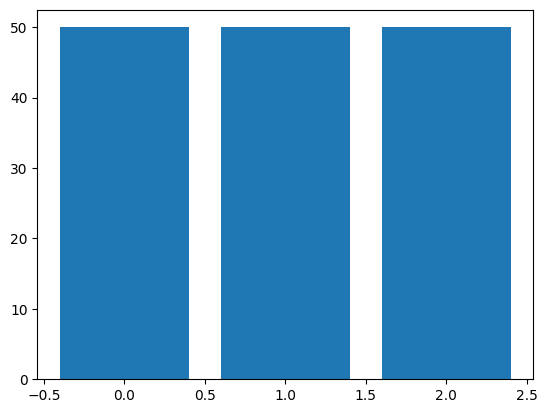

In [2]:
from collections import Counter

def plot_distribution(y):
    labels, q = zip(*sorted(Counter(y).items()))
    plt.bar(labels, q)
    plt.show()

plot_distribution(y)

Entrenaremos un modelo para resolver el problema. Primero, dividiremos los datos en conjuntos de entrenamiento y validación, como es costrumbre, para luego definir nuestro algoritmo de aprendizaje. En este caso, utilizaremos un simple SVM y lo entrenamos sobre los datos:

In [3]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

model = svm.SVC(C=1.0, kernel='linear', gamma=0.5, probability=True)
model = model.fit(X_train, y_train)

Verificamos la performance de nuestro modelo de clasificación:

In [4]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("F1:",f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.62      0.76      0.68        17
           2       0.69      0.53      0.60        17

    accuracy                           0.76        50
   macro avg       0.77      0.76      0.76        50
weighted avg       0.77      0.76      0.76        50

F1: 0.7566315789473684


Simulando un cambio en la distribución de las clases
----------------------------------------------------

La siguiente función nos permitirá alterar la distribución de las observaciones presentes en el set de datos, es decir, generará un nuevo conjunto de datos cuyas proporciones de las observaciones estarán alteradas por el parámetro `weights` que las especifica. Este parametro es un arreglo donde el primer valor corresponde a la proporción de la clase `1 (Setosa)`, el segundo a la `2 (Versicolour)` y el tercero a la `3 (Virginica)`.

In [5]:
def simulate_samples(nsamples, X_source, y_source, weights):
    totals = np.round(np.array(weights) * nsamples).astype(int)
    indices = np.arange(y_source.size)
    new_indices = []
    for i, c in enumerate(np.unique(y_source)):
        new_indices.extend(np.random.choice(indices[y_source==c], totals[i], replace=True))

    y_new = y_source[new_indices]
    X_new = X_source[new_indices,:]
    return(X_new, y_new)

Generemos un nuevo conjunto de datos con las proporciones 10%, 10% y 80%:

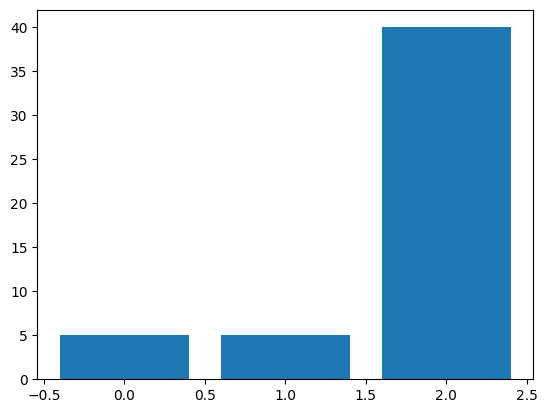

In [6]:
n = 50
weights = np.array([0.10, 0.10, 0.80]) # Nuevas distribuciones
X_new, y_new = simulate_samples(n, X_test, y_test, weights)

plot_distribution(y_new)

Efecto
------
Veamos cual es el efecto en la performance del modelo al cambiar esta distribución:

In [7]:
y_new_pred = model.predict(X_new)
print(classification_report(y_new, y_new_pred))
print("F1:",f1_score(y_new, y_new_pred, average='weighted'))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.20      0.80      0.32         5
           2       0.96      0.60      0.74        40

    accuracy                           0.66        50
   macro avg       0.72      0.80      0.69        50
weighted avg       0.89      0.66      0.72        50

F1: 0.7227692307692307


Podemos ver que ahora la performance del modelo a decaido. Recuerdemos que la puntuación F1 original era ~0,76. lo que significa que el rendimiento de nuestro modelo se ha deteriorado como consecuncia del cambio de la distribución. Incluso, no necesariamente la performance del modelo pudo haber cambiado.

In [8]:
from scipy.stats import wasserstein_distance

print('Distancia entre train y test:', np.round(wasserstein_distance(X_train.flatten(), X_test.flatten()), 2))
print('Distancia entre train y el nuevo set de datos:', np.round(wasserstein_distance(X_train.flatten(), X_new.flatten()), 2))


Distancia entre train y test: 0.1
Distancia entre train y el nuevo set de datos: 0.34


Generalizando el experimento
----------------------------
Para ver el impacto en general, veamos como va cambiando la performance del modelo a medida que la distribución de los datos cambia (especificamente para la clase 2 - Versicolour). Para esto vamos a ir variando el porcentaje desde el 33% (original) hasta un 90%. Al mismo tiempo, computaremos la distancia de Wasserstein entre los conjuntos de datos:

In [9]:
drifting_weights = [np.array([(1-p)/2.0, p, (1-p)/2.0]) for p in np.arange(.33, .90, .05)]

n = 50
scores = { 'proportion': [], 'f1': [], 'distance': [] }
for weights in drifting_weights:
    X_new, y_new = simulate_samples(n, X, y, weights)
    y_new_pred = model.predict(X_new)
    f1 = np.round(f1_score(y_new, y_new_pred, average='weighted'), 2)
    proportion = np.round(weights[1], 2)
    distance = np.round(wasserstein_distance(X_train.flatten(), X_new.flatten()), 2)
    scores['proportion'].append(proportion)
    scores['f1'].append(f1)
    scores['distance'].append(distance)

La siguiente tabla muestra la variación de la performance del modelo a medida que variamos las proporciones de clases. Preste especial atención a que no siempre la performance del modelo se degrada, lo cual es especialmente interesante porque si estuvieramos monitoreando solamente las métricas de performance podriamos dejar de notar el cambio en la distribución de los datos.

In [10]:
results_df = pd.DataFrame(scores)

(results_df
 .style
 .hide_index()
 .bar(color='lightblue', vmin=0, subset=['distance'], align='zero')
 .set_caption('Performance'))

<ipython-input-10-2bf03778c9ca>:5: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  .hide_index()


proportion,f1,distance
0.330000,0.740000,0.100000
0.380000,0.840000,0.100000
0.430000,0.860000,0.110000
0.480000,0.760000,0.060000
0.530000,0.730000,0.150000
0.580000,0.770000,0.150000
0.630000,0.860000,0.190000
0.680000,0.820000,0.160000
0.730000,0.820000,0.170000
0.780000,0.770000,0.250000
